# KJW_Final_Project_DS620 - Part 2

## Creating a Network Graph based on Lexical Similarity of weekly discussion

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data Loading and Preparation" data-toc-modified-id="Data Loading and Preparation"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Loading and Preparation</a></span></li><li><span><a href="#Calculating Lexical Similarity" data-toc-modified-id="Calculating Lexical Similarity"><span class="toc-item-num">2&nbsp;&nbsp;</span>Calculating Lexical Similarity</a></span></li><li><span><a href="#Network Graph based on Lexical Similarity" data-toc-modified-id="Network Graph based on Lexical Similarity"><span class="toc-item-num">3&nbsp;&nbsp;</span>Network Graph based on Lexical Similarity</a></span></li></ul></div>

<a id = 'Data Loading and Preparation'></a>

#### Objective
In this part 2 of the final project, we move to creating a third and final social network graph of all the students in the DS620 Summer 2020 class where the "strength of the ties" i.e. edges are based on the lexical similarity i.e. common content in the weekly discussion posts made by the students on the CUNY Blackboard site. We use the NLTK and Gensim libraries for determining lexical similarity, NetworkX for social network analysis, along with the standard libraries such as Pandas and Numpy.

#### Link to Youtube video for part 2

https://youtu.be/n7QKae0e5CA

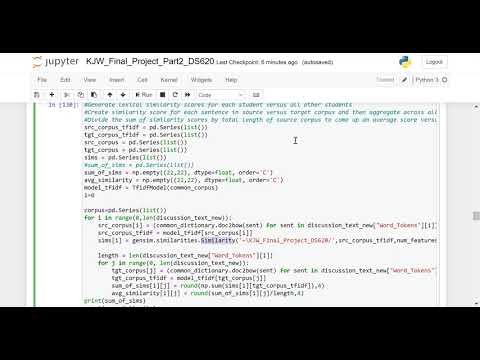

In [138]:
from IPython.display import YouTubeVideo
YouTubeVideo("n7QKae0e5CA")

### Data Loading and Preparation

In [111]:
#Import the required libraries

import networkx as nx
import pandas as pd
import numpy as np
import nltk
import gensim
from gensim import similarities, corpora, models
from gensim.similarities.docsim import Similarity
from gensim.test.utils import common_corpus, common_dictionary, get_tmpfile
from gensim.corpora import Dictionary
from gensim.similarities import MatrixSimilarity, Similarity
from gensim.utils import lemmatize
from gensim.models import TfidfModel
from nltk.tokenize import word_tokenize, sent_tokenize
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
stop = stopwords.words('english')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [112]:
#Load in the weekly discussion data for the DS620 Summer 2020 class from the Blackboard website
discussion_df=pd.read_csv("DS620_Discussion_Data_Final.csv")

In [113]:
#Check if the data loaded properly
discussion_df.iloc[1,:]

Thread_Name                Google Ads                                                                                                                                                                                                                                                                                                                                                                                                                                                 
Initial_Post_or_Comment    2                                                                                                                                                                                                                                                                                                                                                                                                                                                          
Author                     Zachary Alexander              

In [114]:
#Check dataframe dimensions
discussion_df.shape

(379, 5)

In [115]:
#Create a new dataframe to retain only the Author, Response to and the actual discussion post or comment
edge_list_2=discussion_df.iloc[:,2:4]

In [116]:
#Rename the column names
edge_list_2.columns = ["Node1","Node2"]

In [117]:
#Combine the name of the discussion thread and the content
#discussion_df.Combined=discussion_df.Thread_Name+" "+discussion_df.Thread_Content
discussion_df['Combined'] = discussion_df[['Thread_Name', 'Thread_Content']].apply(lambda x: ' '.join(x), axis=1)

In [118]:
#Check if the name of the discussion thread and the content were combined correctly
discussion_df.Combined[0]

"Google Ads Google Ads provides analytic reporting on how people use a website.\xa0Google Analytics tracks what people do after clicking an ad.\xa0It traces\xa0and provides information on how people found a particular website, and how the website was explored.\xa0 Using the information,\xa0a website owner can identify trends and generate ideas to enhance their website. For example,\xa0you can learn how much time is spent on a site, what items were browsed, and what items were placed in the cart. Those factors can provide leads on enhancing customers' experience, which in turn can help increase\xa0conversions\xa0like sales and\xa0return on ad spend."

In [119]:
#Check the data structure of the new dataframe
discussion_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Thread_Name              379 non-null    object
 1   Initial_Post_or_Comment  379 non-null    int64 
 2   Author                   379 non-null    object
 3   Response_To              379 non-null    object
 4   Thread_Content           379 non-null    object
 5   Combined                 379 non-null    object
dtypes: int64(1), object(5)
memory usage: 17.9+ KB


In [120]:
#Check dataframe contents for few records
discussion_df.head(2)

,Thread_Name,Initial_Post_or_Comment,Author,Response_To,Thread_Content,Combined
0,Google Ads,1,Vanita Thompson,Vanita Thompson,"Google Ads provides analytic reporting on how people use a website. Google Analytics tracks what people do after clicking an ad. It traces and provides information on how people found a particular website, and how the website was explored. Using the information, a website owner can identify trends and generate ideas to enhance their website. For example, you can learn how much time is spent on a site, what items were browsed, and what items were placed in the cart. Those factors can provide leads on enhancing customers' experience, which in turn can help increase conversions like sales and return on ad spend.","Google Ads Google Ads provides analytic reporting on how people use a website. Google Analytics tracks what people do after clicking an ad. It traces and provides information on how people found a particular website, and how the website was explored. Using the information, a website owner can identify trends and generate ideas to enhance their website. For example, you can learn how much time is spent on a site, what items were browsed, and what items were placed in the cart. Those factors can provide leads on enhancing customers' experience, which in turn can help increase conversions like sales and return on ad spend."
1,Google Ads,2,Zachary Alexander,Vanita Thompson,"Hi Vanita -- I definitely agree that Google Ads provides a really good platform for analytical reporting and marketing. I used to work pretty closely with Google's suite of marketing tools and think they are really advanced in their ability to measure advertisement/marketing reach, as well as user and website activity! Google Analytics has continued to a leader on this front, and I'm curious to see if we talk much about this in our course!","Google Ads Hi Vanita -- I definitely agree that Google Ads provides a really good platform for analytical reporting and marketing. I used to work pretty closely with Google's suite of marketing tools and think they are really advanced in their ability to measure advertisement/marketing reach, as well as user and website activity! Google Analytics has continued to a leader on this front, and I'm curious to see if we talk much about this in our course!"


In [121]:
#Filter only the Author, Response to and Combined content columns
discussion_text=discussion_df.iloc[:,[2,5]]

In [122]:
# Combine all posts by a given student across different weeks i.e. create aggregated content grouped by Author
#discussion_text_new = pd.DataFrame(discussion_text.groupby('Author').agg({'Combined':lambda x: ', '.join(x)}))
discussion_text_new = pd.DataFrame(discussion_text.groupby('Author').agg({'Combined':lambda x: ', '.join(x)}).reset_index())

In [123]:
# Set display options
pd.set_option('display.max_colwidth', -1)

In [124]:
# Check length of dataframe after combining - it has 22 records as expected - one for each student
len(discussion_text_new)

22

In [125]:
#Check number of authors i.e. students
node=discussion_text_new.Author
node.Name ='Node_Name'
node

0     Abdellah Ait Elmouden
1     Amber Ferger         
2     Elina Azrilyan       
3     Habib Khan           
4     Jack Russo           
5     Jagdish Chhabria     
6     Jeremy O'Brien       
7     Jit Seneviratne      
8     Ken Popkin           
9     Mael Illien          
10    Mia Chen             
11    Mikhail Kollontai    
12    Murat Akyildirim     
13    Priya Shaji          
14    Sheryl Piechocki     
15    Simon Ustoyev        
16    Steven Ellingson     
17    Subhalaxmi Rout      
18    Vanita Thompson      
19    Vijaya Cherukuri     
20    Willie Smalls        
21    Zachary Alexander    
Name: Author, dtype: object

As expected, there are 22 students in the class

In [126]:
#Functions used below to clean data
def remove_stop_words(inclean):
    stop_words = stopwords.words('english')
    words = inclean.split()
    outclean = ''
    
    for word in words:
        if word not in stop_words:
            outclean = outclean + ' ' + word
    
    return outclean
    
def remove_common_words(inclean):
    words = inclean.split()
    outclean = ''
    
    for word in words:
        if word not in common_words:
            outclean = outclean + ' ' + word
    
    return outclean

def remove_url(inclean):
    outclean = re.sub(r"http\S+", "", inclean) 
    
    return outclean

In [127]:
#Create sentence and word tokens, after cleaning the discussion content
#word_tokens=pd.Series(str(list()))
sentences=[]
clean=[]
all_sentences=[]
discussion_text_new['Word_Tokens']=np.nan
discussion_text_new['Sentence_Tokens']=np.nan
tokenizer = nltk.RegexpTokenizer(r"\w+")

for i in range(len(discussion_text_new)):
    clean = discussion_text_new.Combined[i].lower()     #lower case
    clean = remove_stop_words(clean)
    clean = remove_url(clean)
    sentence_tokens[i] = nltk.sent_tokenize(clean)
    sentence_tokens[i] = (s.strip('.') for s in sentence_tokens[i])
    sentence_tokens[i] = (s.strip(',') for s in sentence_tokens[i])
    sentence_tokens[i] = (s.strip(':') for s in sentence_tokens[i])
    sentence_tokens[i] = (s.strip(';') for s in sentence_tokens[i])
    sentence_tokens[i] = (s.strip(' ') for s in sentence_tokens[i])
    sentence_tokens[i] = (s.strip('-') for s in sentence_tokens[i])
    sentence_tokens[i] = (s.strip(')') for s in sentence_tokens[i])
    sentence_tokens[i] = (s.strip('(') for s in sentence_tokens[i])
discussion_text_new["Sentence_Tokens"]=sentence_tokens

#    print(f'Tokenining {discussion_text_new.Author[i]}')
for i in range(len(discussion_text_new)):
    sentences=[]
    for sent in discussion_text_new["Sentence_Tokens"][i]:
        sentences.append(nltk.word_tokenize(sent))
        all_sentences.append(nltk.word_tokenize(sent))
    discussion_text_new["Word_Tokens"][i]=sentences
        

In [128]:
# Check total number of "sentences" posted by each student across all discussion posts
length=0
total_length=0
all_sents=[]
# word_tokens[i]
for i in range(len(discussion_text_new)):
    length = len(discussion_text_new["Word_Tokens"][i])
    total_length=total_length+length
    print(f"{discussion_text_new['Author'][i]} has {length} sentences")
print(f"There are a total of {total_length} sentences across all discussion posts")

Abdellah Ait Elmouden has 61 sentences
Amber Ferger has 158 sentences
Elina Azrilyan has 61 sentences
Habib Khan has 53 sentences
Jack Russo has 37 sentences
Jagdish Chhabria has 65 sentences
Jeremy O'Brien has 36 sentences
Jit Seneviratne has 68 sentences
Ken Popkin has 70 sentences
Mael Illien has 95 sentences
Mia Chen has 20 sentences
Mikhail Kollontai has 85 sentences
Murat Akyildirim has 116 sentences
Priya Shaji has 63 sentences
Sheryl Piechocki has 73 sentences
Simon Ustoyev has 46 sentences
Steven Ellingson has 49 sentences
Subhalaxmi Rout has 139 sentences
Vanita Thompson has 48 sentences
Vijaya Cherukuri has 76 sentences
Willie Smalls has 46 sentences
Zachary Alexander has 101 sentences
There are a total of 1566 sentences across all discussion posts


<a id = 'Calculating Lexical Similarity'></a>

### Calculating Lexical Similarity

This section uses the Gensim library to compare the main content of each student's discussion posts (aggregated across all weeks and after removing stop words) to every other student. The main idea is to calculate a similarity score between sentences based on co-occurrence of words, and then averaging this score across all sentences. In order to do this, we create a common dictionary and bag of words for all words across all posts by all students.

In [129]:
#Create common dictionary of all words across all posts by all students and map each word token to a uniqye numeric id
#Create common corpus of all sentences i.e. bag of words
common_dictionary = Dictionary(all_sentences)
common_dictionary.token2id
common_corpus = [common_dictionary.doc2bow(sent) for sent in all_sentences]


In [130]:
#Generate lexical similarity scores for each student versus all other students
#Create similarity score for each sentence in source versus target corpus and then aggregate across all sentences
#Divide the sum of similarity scores by total length of source corpus to come up an average score versus all target corpuses
src_corpus_tfidf = pd.Series(list())
tgt_corpus_tfidf = pd.Series(list())
src_corpus = pd.Series(list())
tgt_corpus = pd.Series(list())
sims = pd.Series(list())
#sum_of_sims = pd.Series(list())
sum_of_sims = np.empty((22,22), dtype=float, order='C')
avg_similarity = np.empty((22,22), dtype=float, order='C')
model_tfidf = TfidfModel(common_corpus)
i=0

corpus=pd.Series(list())
for i in range(0,len(discussion_text_new)):
    src_corpus[i] = (common_dictionary.doc2bow(sent) for sent in discussion_text_new["Word_Tokens"][i])
    src_corpus_tfidf = model_tfidf[src_corpus[i]]
    sims[i] = gensim.similarities.Similarity('~\KJW_Final_Project_DS620/',src_corpus_tfidf,num_features=len(common_dictionary))

    length = len(discussion_text_new["Word_Tokens"][i])
    for j in range(0, len(discussion_text_new)):
        tgt_corpus[j] = (common_dictionary.doc2bow(sent) for sent in discussion_text_new["Word_Tokens"][j])
        tgt_corpus_tfidf = model_tfidf[tgt_corpus[j]]
        sum_of_sims[i][j] = round(np.sum(sims[i][tgt_corpus_tfidf]),4)
        avg_similarity[i][j] = round(sum_of_sims[i][j]/length,4)
print(sum_of_sims)
print(avg_similarity)

[[110.50900269  73.89099884  32.49300003  34.95059967  15.23509979
   33.52009964  17.33200073  27.58589935  42.26549911  44.03359985
    9.41819954  32.07040024  63.54190063  33.52959824  27.31360054
   26.30579948  19.53179932  77.42259979  22.55660057  47.68450165
   11.14579964  59.20059967]
 [ 73.89099884 497.04141235  82.10169983  76.76080322  43.88840103
   95.686203    43.40000153  79.97730255 107.47429657 116.26290131
   25.32439995  94.50050354 163.55130005  91.6085968   98.915802
   62.03509903  58.85250092 212.03889465  60.48690033 111.54679871
   34.88610077 163.68170166]
 [ 32.49300003  82.10169983 123.63379669  40.78950119  18.35440063
   34.85079956  16.50869942  34.54159927  39.91239929  47.9864006
   11.02750015  36.27909851  69.56510162  40.69670105  36.60520172
   31.88409996  24.62779999  86.99520111  29.46249962  44.64649963
   13.98950005  66.3690033 ]
 [ 34.95059967  76.76080322  40.78950119 125.68979645  14.91580009
   32.40520096  13.57830048  26.98760033  36.

The pair-wise total lexical similarity scores are shown above as well the average similarity score based on the number of words for each author

In [131]:
#Create upper triangular matrix to retain each score only once
tri_upper_no_diag = np.triu(sum_of_sims, k=1)

In [132]:
#Create a dataframe for the square matrix showing similarity scores
node1 = node2 = discussion_text_new["Author"]
edge_df = pd.DataFrame(data=tri_upper_no_diag, index=node1, columns=node2) 
edge_df

Author,Abdellah Ait Elmouden,Amber Ferger,Elina Azrilyan,Habib Khan,Jack Russo,Jagdish Chhabria,Jeremy O'Brien,Jit Seneviratne,Ken Popkin,Mael Illien,Mia Chen,Mikhail Kollontai,Murat Akyildirim,Priya Shaji,Sheryl Piechocki,Simon Ustoyev,Steven Ellingson,Subhalaxmi Rout,Vanita Thompson,Vijaya Cherukuri,Willie Smalls,Zachary Alexander
Author,,,,,,,,,,,,,,,,,,,,,,
Abdellah Ait Elmouden,0.0,73.890999,32.4930,34.950600,15.235100,33.520100,17.332001,27.585899,42.265499,44.033600,9.4182,32.070400,63.541901,33.529598,27.313601,26.305799,19.531799,77.422600,22.556601,47.684502,11.145800,59.200600
Amber Ferger,0.0,0.000000,82.1017,76.760803,43.888401,95.686203,43.400002,79.977303,107.474297,116.262901,25.3244,94.500504,163.551300,91.608597,98.915802,62.035099,58.852501,212.038895,60.486900,111.546799,34.886101,163.681702
Elina Azrilyan,0.0,0.000000,0.0000,40.789501,18.354401,34.850800,16.508699,34.541599,39.912399,47.986401,11.0275,36.279099,69.565102,40.696701,36.605202,31.884100,24.627800,86.995201,29.462500,44.646500,13.989500,66.369003
Habib Khan,0.0,0.000000,0.0000,0.000000,14.915800,32.405201,13.578300,26.987600,36.950802,41.736401,12.5604,36.711498,73.953300,33.592899,34.120701,26.694201,22.657200,76.691399,24.863400,53.990200,9.939000,64.092499
Jack Russo,0.0,0.000000,0.0000,0.000000,0.000000,18.621401,8.636500,16.936600,23.649599,24.100401,4.5001,21.637899,30.455400,15.436900,18.151400,13.300400,13.691000,36.665901,13.152100,17.237000,6.474900,34.408901
Jagdish Chhabria,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,19.369499,34.012100,50.103001,46.071400,12.4856,42.728401,74.875298,38.478802,32.242901,29.122601,25.854900,86.106499,27.527100,39.705502,17.709999,71.667503
Jeremy O'Brien,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,18.589100,26.814100,21.419100,6.8283,18.218000,38.403301,17.490801,17.699600,15.652700,12.744500,38.637600,10.625400,17.500401,8.969500,34.383900
Jit Seneviratne,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,38.647701,44.182800,10.4193,33.713200,63.692501,35.653099,34.397301,26.368000,20.022100,75.944801,30.709499,36.056400,12.991600,57.368099
Ken Popkin,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.944698,13.3196,54.919399,81.421997,45.222801,43.308399,34.328602,31.516001,93.159500,28.932600,47.406502,19.890900,84.667099


In [133]:
#Stack the dataframe results into a different format. The similarity score is the weight for the new graph to be created
#newdf=pd.DataFrame(data=edge_df.where(pd.np.triu(pd.np.ones(edge_df.shape), k=1).astype(bool)).reset_index().stack(),columns=cols)
node1=[]
node2=[]
weight=[]
edge_data = edge_df.where(pd.np.triu(pd.np.ones(edge_df.shape), k=1).astype(bool)).stack()

for i in range(0,len(edge_data)):
    node1.append(edge_data.index[i][0])
    node2.append(edge_data.index[i][1])
    weight.append(edge_data.values[i])
list_of_tuples = list(zip(node1, node2, weight)) 
newdf = pd.DataFrame(list_of_tuples, columns = ['Node1', 'Node2', 'Weight']) 
newdf


,Node1,Node2,Weight
0,Abdellah Ait Elmouden,Amber Ferger,73.890999
1,Abdellah Ait Elmouden,Elina Azrilyan,32.493000
2,Abdellah Ait Elmouden,Habib Khan,34.950600
3,Abdellah Ait Elmouden,Jack Russo,15.235100
4,Abdellah Ait Elmouden,Jagdish Chhabria,33.520100
5,Abdellah Ait Elmouden,Jeremy O'Brien,17.332001
6,Abdellah Ait Elmouden,Jit Seneviratne,27.585899
7,Abdellah Ait Elmouden,Ken Popkin,42.265499
8,Abdellah Ait Elmouden,Mael Illien,44.033600
9,Abdellah Ait Elmouden,Mia Chen,9.418200


The pair-wise similarity scores above are now in a suitable form to be used in the next section for creating a social network graph

<a id = 'Network Graph based on Lexical Similarity'></a>

### Network Graph with edges based on lexical similarity

We now use the lexical similarity scores as edge weights for the third and final social network graph among the students of DS620 Summer 2020 class. Nodes with thicker edges show more similarity in terms of content of their respective discussion posts. This would indicate a common affinity for topics and interests.

In [134]:
#Create a network graph based on the student nodes with edge weights based on lexical similarity
g_lexsim=nx.Graph()
g_lexsim.add_weighted_edges_from(zip(newdf['Node1'], newdf['Node2'], newdf['Weight']),label='lexical similarity',edge_attr=True)


In [135]:
#Scale the weights uniformly to make it easier to plot edges with weights as the thickness
weights = newdf['Weight']/100

<Figure size 1080x1080 with 0 Axes>

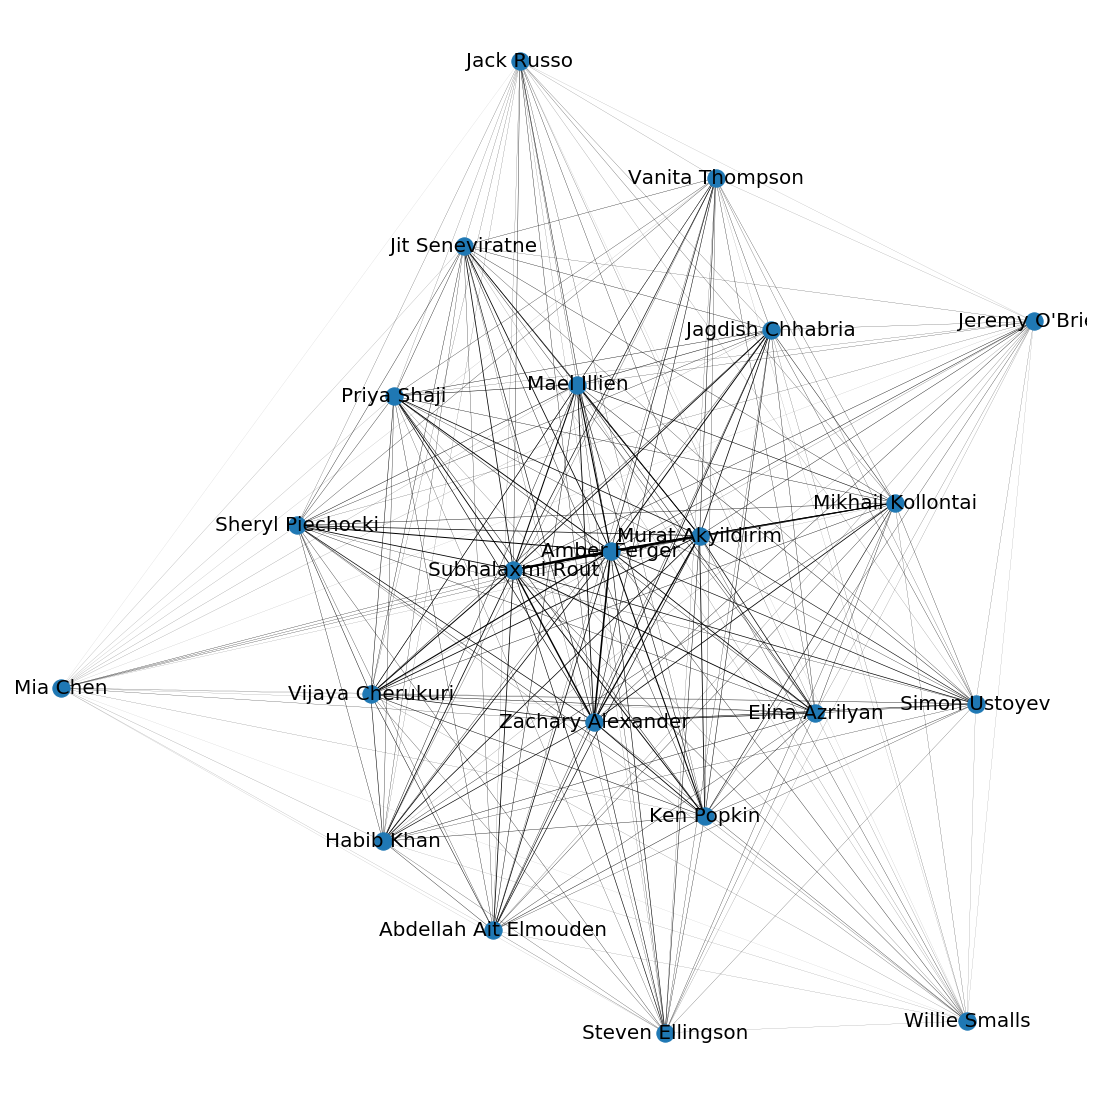

In [136]:
#Format Graph
plt.figure(figsize=(15,15)) 

#Draw the network graph with weights and labels
plt.figure(figsize=(15,15))
nx.draw(g_lexsim, with_labels=True, font_size=20, width = weights,)

In [137]:
#View the edges with weights
g_lexsim.edges(data='weight')

EdgeDataView([('Abdellah Ait Elmouden', 'Amber Ferger', 73.89099884033203), ('Abdellah Ait Elmouden', 'Elina Azrilyan', 32.49300003051758), ('Abdellah Ait Elmouden', 'Habib Khan', 34.950599670410156), ('Abdellah Ait Elmouden', 'Jack Russo', 15.235099792480469), ('Abdellah Ait Elmouden', 'Jagdish Chhabria', 33.52009963989258), ('Abdellah Ait Elmouden', "Jeremy O'Brien", 17.332000732421875), ('Abdellah Ait Elmouden', 'Jit Seneviratne', 27.585899353027344), ('Abdellah Ait Elmouden', 'Ken Popkin', 42.265499114990234), ('Abdellah Ait Elmouden', 'Mael Illien', 44.033599853515625), ('Abdellah Ait Elmouden', 'Mia Chen', 9.41819953918457), ('Abdellah Ait Elmouden', 'Mikhail Kollontai', 32.07040023803711), ('Abdellah Ait Elmouden', 'Murat Akyildirim', 63.541900634765625), ('Abdellah Ait Elmouden', 'Priya Shaji', 33.529598236083984), ('Abdellah Ait Elmouden', 'Sheryl Piechocki', 27.313600540161133), ('Abdellah Ait Elmouden', 'Simon Ustoyev', 26.30579948425293), ('Abdellah Ait Elmouden', 'Steven E

### References

1. We used this article as an example to calculate lexical similarity of documents [Compare documents similarity using Python | NLP](https://dev.to/coderasha/compare-documents-similarity-using-python-nlp-4odp) to calculate cosine similarity with the Gensim package.

2. We learnt more about Gensim from this article [Gensim Tutorial - A Complete Beginner's Guide](https://www.machinelearningplus.com/nlp/gensim-tutorial/) 


We now move on to the third and final part of the project, where we use NLP to do additional analysis on the content of the discussion posts. This is done in a separate notebook.